<a href="https://colab.research.google.com/github/mshitie/MS_KD/blob/main/WithoutKD/WithoutKD_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install rarfile

from google.colab import drive
import rarfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to the .rar file in Google Drive
rar_path = '/content/drive/MyDrive/computer_vision/main_data_croped.rar'

# Destination folder to extract the contents
destination_folder = '/content'

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Extract the .rar file
with rarfile.RarFile(rar_path, 'r') as rar_ref:
    rar_ref.extractall(destination_folder)

print("Extraction completed.")

Mounted at /content/drive
Extraction completed.


In [2]:
import os
import cv2
from PIL import Image
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import auc, roc_curve
from tqdm import tqdm

import time

<ipython-input-2-c760a79cdaf2>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
# Keras & Tensorflow
import keras
import tensorflow as tf
from keras import layers
from keras.models import Model
from keras.layers import Lambda, concatenate
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D , Conv2D , MaxPooling2D
from keras.layers import  Dropout , BatchNormalization , Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from keras.callbacks import Callback , ReduceLROnPlateau , ModelCheckpoint
from sklearn.metrics import cohen_kappa_score, accuracy_score
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy

In [4]:

# trachoma main dataset binary image classification
import os
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Set the path to the directory containing the dataset
dataset_dir = '/content/main_data_croped'

# Read the CSV file
data = pd.read_csv(os.path.join(dataset_dir, '/content/drive/MyDrive/computer_vision/tfti2.csv'), usecols=["key", "class"])

# Convert the 'class' column to string
data['class'] = data['class'].astype(str)

# Filter the data to include only classes 1 and 2
data = data[data['class'].isin(['1', '2', '3'])]

# Split the data into training, validation, and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=0)
valid_data, test_data = train_test_split(test_data, test_size=0.5, random_state=0)

# Print the number of samples in each set
print('Number of train samples:', train_data.shape[0])
print('Number of valid samples:', valid_data.shape[0])
print('Number of test samples:', test_data.shape[0])

# Preprocess data
train_data["key"] = train_data["key"].apply(lambda x: x + ".jpg")
valid_data["key"] = valid_data["key"].apply(lambda x: x + ".jpg")
test_data["key"] = test_data["key"].apply(lambda x: x + ".jpg")

BATCH_SIZE = 16
HEIGHT = 224
WIDTH = 224
N_CLASSES = 3

# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=dataset_dir,
    x_col="key",
    y_col="class",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    target_size=(HEIGHT, WIDTH),
    seed=0
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_data,
    directory=dataset_dir,
    x_col="key",
    y_col="class",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    target_size=(HEIGHT, WIDTH),
    seed=0
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=dataset_dir,
    x_col="key",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    target_size=(HEIGHT, WIDTH),
    seed=0
)





Number of train samples: 1195
Number of valid samples: 149
Number of test samples: 150
Found 1195 validated image filenames belonging to 3 classes.
Found 149 validated image filenames belonging to 3 classes.
Found 150 validated image filenames belonging to 3 classes.


In [5]:
# MobileNet
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, regularizers
def mobile_model1(backbone , lr = 1e-4):
  model1 = Sequential()
  model1.add(backbone)
  model1.add(layers.GlobalAveragePooling2D())
  model1.add(layers.Dropout(0.5))
  model1.add(layers.BatchNormalization())
  model1.add(layers.Dense(N_CLASSES, activation='softmax', kernel_regularizer=regularizers.l2(0.01), name='output'))

  model1.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )

  return model1


mobilenet1 = MobileNet(
    weights = 'imagenet',
    include_top = False,
    input_shape =(224 , 224 , 3)
)
#call the model
model1 = mobile_model1(mobilenet1 , lr = 1e-4)
model1.build((None, 224, 224, 3))
model1.summary()

17225924/17225924 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 output (Dense)              (None, 3)                 30

In [6]:
# Training the teacher model with Resnet50
# Train the teacher model as usual
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-7)
epochs = 50
batch_size = 32
teacher_his = model1.fit(train_generator,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=valid_generator,
                           callbacks=[reduce_lr])

Epoch 1/50
75/75 - 49s - loss: 1.3491 - accuracy: 0.5063 - val_loss: 2.8987 - val_accuracy: 0.1208 - lr: 1.0000e-04 - 49s/epoch - 658ms/step
Epoch 2/50
75/75 - 20s - loss: 1.1293 - accuracy: 0.5833 - val_loss: 1.6583 - val_accuracy: 0.3020 - lr: 1.0000e-04 - 20s/epoch - 273ms/step
Epoch 3/50
75/75 - 21s - loss: 0.9383 - accuracy: 0.6594 - val_loss: 1.2715 - val_accuracy: 0.5503 - lr: 1.0000e-04 - 21s/epoch - 279ms/step
Epoch 4/50
75/75 - 22s - loss: 0.8897 - accuracy: 0.6745 - val_loss: 0.6963 - val_accuracy: 0.7450 - lr: 1.0000e-04 - 22s/epoch - 295ms/step
Epoch 5/50
75/75 - 20s - loss: 0.7709 - accuracy: 0.7113 - val_loss: 0.4468 - val_accuracy: 0.8255 - lr: 1.0000e-04 - 20s/epoch - 268ms/step
Epoch 6/50
75/75 - 23s - loss: 0.7364 - accuracy: 0.7456 - val_loss: 0.3888 - val_accuracy: 0.8993 - lr: 1.0000e-04 - 23s/epoch - 312ms/step
Epoch 7/50
75/75 - 23s - loss: 0.6670 - accuracy: 0.7757 - val_loss: 0.4696 - val_accuracy: 0.8591 - lr: 1.0000e-04 - 23s/epoch - 302ms/step
Epoch 8/50
75

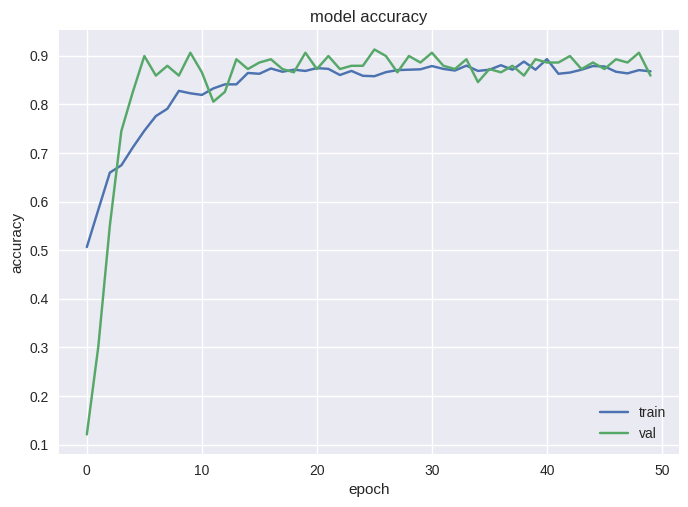

In [7]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(teacher_his.history['accuracy'],)
plt.plot(teacher_his.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

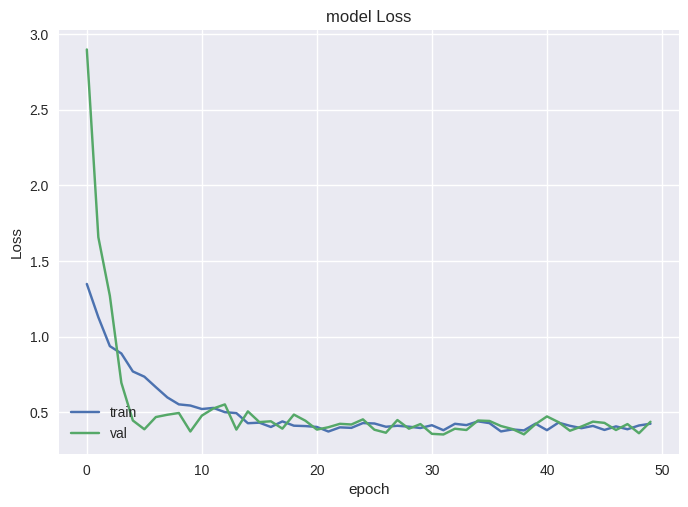

In [8]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(teacher_his.history['loss'])
plt.plot(teacher_his.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower left')
plt.show()

In [9]:
# Evaluate the model on the test set
import timeit

start = timeit.default_timer()
test_loss, test_acc = model1.evaluate(
    test_generator,
    verbose=0
)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

Test loss: 0.5466015934944153
Test accuracy: 0.8333333134651184

Time:  0.8295308360000035 sec


In [10]:
from sklearn.metrics import classification_report

# Assuming you have a model named 'model_vgg2' and a test generator named 'test_generator'
# Generate predictions for the test data
y_pred = model1.predict(test_generator)

# Convert predictions from probabilities to class labels
y_pred_labels = y_pred.argmax(axis=1)

# Get the true labels from the test generator
y_true = test_generator.classes

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Generate the classification report
report = classification_report(y_true, y_pred_labels, target_names=class_labels)

# Print the classification report
print(report)

10/10 [==============================] - 2s 72ms/step
              precision    recall  f1-score   support

           1       0.87      0.94      0.91       103
           2       0.85      0.59      0.70        37
           3       0.46      0.60      0.52        10

    accuracy                           0.83       150
   macro avg       0.73      0.71      0.71       150
weighted avg       0.84      0.83      0.83       150

